# Step 1: Load the BTC dataset

In [5]:
from datasets import load_dataset

# Load the BTC dataset
dataset = load_dataset("tner/btc")

# View the amount of data for each split
print(dataset)

# Take a look at the contents of a sample
print(dataset['train'][0])

# View tag dictionary
label_names = dataset['train'].features['tags'].feature.names
print(label_names)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 6338
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1001
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 2000
    })
})
{'tokens': ['I', 'hate', 'the', 'words', 'chunder', ',', 'vomit', 'and', 'puke', '.', 'BUUH', '.'], 'tags': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]}
['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-ORG', 'I-PER', 'O']


The Token field is 'tokens'

The tag field is 'tags
'
Tags use BIO coding, there are 6 types of entities + O (non-entitie
s)
Labels that have been mapped to integers can be mapped back using the.names attribute of ClassLabel

# Step 2: Prepare BERT model and tokenizer

2.1 Select a model & tokenizer

We use the pretrained model that suits the English language (e.g. bert-base-cased suits NER better because it preserves case) :


In [7]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_names)  # The number of labels must match
)


D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2.2 Align tokens and labels

BERT tokenizer might cut a word into multiple subwords (e.g. "Washington" → "Wash" + "##ington"). At this point we need: 

• Primary token allocation tags 

• Remaining sub-tokens allocation -100 (ignoring losses)



In [9]:
from transformers import DataCollatorForTokenClassification
from datasets import ClassLabel
import torch

label_all_tokens = False  # Only annotate the first sub-token, and ignore the others with -100

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["tags"][word_idx])
        else:
            labels.append(example["tags"][word_idx] if label_all_tokens else -100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply to the data set
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=False)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

2.3 Prepare DataLoader

In [11]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)



# Step 3: Train the model: BRET

3.1 Setting training parameters

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=r"D:\coursework_data\Text_Analytics_task3\results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)


3.2 Evaluation functions (F1, precision, recall)

In [15]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Gets a list of label names
label_list = dataset["train"].features["tags"].feature.names

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(predictions, labels)
    ]

    results = precision_recall_fscore_support(
        [l for seq in true_labels for l in seq],
        [p for seq in true_predictions for p in seq],
        average="macro"
    )

    return {
        "precision": results[0],
        "recall": results[1],
        "f1": results[2],
    }


3.3 Initialize the Trainer and train

In [19]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
# Re-create the trainer instance (as before), and only run one round, which can be increased to three later
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],  
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Evaluation
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 2.013376235961914, 'eval_precision': 0.12553510039631674, 'eval_recall': 0.11764448488303546, 'eval_f1': 0.04221928809422489, 'eval_runtime': 150.54, 'eval_samples_per_second': 13.286, 'eval_steps_per_second': 0.83}


Analyzing code: Error flag example

In [21]:
from transformers import Trainer
import numpy as np

# Get prediction results
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions, axis=2)

# Gets a list of label names
label_list = dataset["train"].features["tags"].feature.names

# Show incorrect sample
def show_errors(n=5):
    shown = 0
    for i in range(len(preds)):
        input_ids = tokenized_datasets["test"][i]["input_ids"]
        tokens = tokenizer.convert_ids_to_tokens(input_ids)
        
        true_tag_ids = labels[i]
        pred_tag_ids = preds[i]
        
        # Only tokens whose value is not -100
        filtered_tokens = []
        true_tags = []
        pred_tags = []
        
        for t, true_id, pred_id in zip(tokens, true_tag_ids, pred_tag_ids):
            if true_id != -100:
                filtered_tokens.append(t)
                true_tags.append(label_list[true_id])
                pred_tags.append(label_list[pred_id])
        
        # If there is a prediction error, output
        if true_tags != pred_tags:
            print(f"Sample #{i}")
            print("TOKENS     :", filtered_tokens)
            print("TRUE TAGS  :", true_tags)
            print("PREDICTED  :", pred_tags)
            print("=" * 70)
            shown += 1
        if shown >= n:
            break

# The first 5 incorrect samples
show_errors(n=5)


Sample #0
TOKENS     : ['@', 'co', 'hey', ',', 'con', 'to', 'you', 'and', 'the', 'team', '!', 'Always', 'worth', 'a', 'read', ':']
TRUE TAGS  : ['B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
PREDICTED  : ['O', 'I-PER', 'B-PER', 'I-ORG', 'I-PER', 'I-ORG', 'I-PER', 'O', 'B-PER', 'B-PER', 'B-PER', 'I-ORG', 'I-PER', 'B-LOC', 'I-ORG', 'B-PER']
Sample #1
TOKENS     : ['This', 'morning', 'I', 'met', 'with', 'Senators', 'In', 'and', 'Senior', 'from', 'Pa', 'to', 'discuss', 'my', 'role', 'as', 'Chair', 'of', 'the', 'Public', 'Works', '.', '.', '.', 'http']
TRUE TAGS  : ['O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'B-PER', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
PREDICTED  : ['O', 'I-LOC', 'I-ORG', 'I-LOC', 'B-LOC', 'B-PER', 'I-ORG', 'B-PER', 'B-PER', 'B-PER', 'O', 'B-LOC', 'B-LOC', 'I-ORG', 'I-LOC', 'B-LOC', 'B-PER', 'B-PER', 'B-PER', 'B-PER', 'I-ORG', 'O', 'O', 'I-ORG', 'I-ORG']
Sample #2
TOKENS     : ['En', 

# Step 4: Change to BERTweet 

Load the BERTweet model and tokenizer

In [23]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Use BERTweet
model_checkpoint = "vinai/bertweet-base"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)  # Note that use_fast=False is required for BERTweet
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list)  # The number of labels must be consistent
)


D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Re-token alignment (using the original function)



In [25]:
# Redefine the tokenize_and_align_labels
def tokenize_and_align_labels(example):
    tokenized_input_ids = []
    label_ids = []

    for word, label in zip(example["tokens"], example["tags"]):
        # Tokenize this word using Bertweet's tokenize()
        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            continue  # Skip empty tokens

        # Convert tokens to input IDs
        input_ids = tokenizer.convert_tokens_to_ids(word_tokens)
        tokenized_input_ids.extend(input_ids)

        # Mark the first sub-token, and ignore the rest with -100
        label_ids.extend([label] + [-100] * (len(word_tokens) - 1))

    # Truncate + padding to the maximum length (here we fix max_length = 128)
    max_length = 128
    tokenized_input_ids = tokenized_input_ids[:max_length]
    label_ids = label_ids[:max_length]

    padding_length = max_length - len(tokenized_input_ids)
    tokenized_input_ids += [tokenizer.pad_token_id] * padding_length
    label_ids += [-100] * padding_length

    attention_mask = [1 if id != tokenizer.pad_token_id else 0 for id in tokenized_input_ids]

    return {
        "input_ids": tokenized_input_ids,
        "attention_mask": attention_mask,
        "labels": label_ids
    }

In [27]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=False)

Map:   0%|          | 0/6338 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Set new output path + training parameters

In [68]:
training_args = TrainingArguments(
    output_dir=r"D:\coursework_data\Text_Analytics_task3\results_bertweet",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # For 1 epoch first
    weight_decay=0.01,
    logging_dir=r"D:\coursework_data\Text_Analytics_task3\logs_bertweet",
    logging_steps=20,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)


Trainer + training + evaluation, for 1 epoch

In [72]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Output final evaluation results
eval_results = trainer.evaluate()
print("BERTweet Final Evaluation Results:")
for k, v in eval_results.items():
    if k.startswith("eval_"):
        print(f"{k}: {v:.4f}")


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.190300,0.187247,0.793353,0.679536,0.721737


BERTweet Final Evaluation Results:
eval_loss: 0.1872
eval_precision: 0.7934
eval_recall: 0.6795
eval_f1: 0.7217
eval_runtime: 368.5129
eval_samples_per_second: 5.4270
eval_steps_per_second: 0.3390


Train 3 epoch

In [31]:
# Set training parameters, including early stopping automatically enabled (based on best f1)
training_args = TrainingArguments(
    output_dir=r"D:\coursework_data\Text_Analytics_task3\results_bertweet_3epochs",
    evaluation_strategy="epoch",            # Evaluate each epoch once
    save_strategy="epoch",                  # Each epoch saves the model
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,                     # 3 rounds of training
    weight_decay=0.01,
    logging_dir=r"D:\coursework_data\Text_Analytics_task3\logs_bertweet_3epochs",
    logging_steps=20,
    save_total_limit=1,                     # Keep an optimal model
    load_best_model_at_end=True,            # Automatically use the best model
    metric_for_best_model="f1",             # Based on f1 early stop
    greater_is_better=True                  # f1 the bigger the better
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Output the evaluation metrics of the final model on the test set
eval_results = trainer.evaluate()
print("Final Evaluation Results (BERTweet + Early Stop):")
for k, v in eval_results.items():
    if k.startswith("eval_"):
        print(f"{k}: {v:.4f}")

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.169100,0.170078,0.766539,0.759195,0.756354
2,0.119200,0.137308,0.800693,0.795848,0.797104
3,0.117700,0.134784,0.807429,0.797451,0.800384


Final Evaluation Results (BERTweet + Early Stop):
eval_loss: 0.1348
eval_precision: 0.8074
eval_recall: 0.7975
eval_f1: 0.8004
eval_runtime: 359.2703
eval_samples_per_second: 5.5670
eval_steps_per_second: 0.3480


Error example

In [34]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions, axis=2)

label_list = dataset["train"].features["tags"].feature.names

def show_errors(n=5):
    shown = 0
    for i in range(len(preds)):
        input_ids = tokenized_datasets["test"][i]["input_ids"]
        tokens = tokenizer.convert_ids_to_tokens(input_ids)
        
        true_tag_ids = labels[i]
        pred_tag_ids = preds[i]
        
        filtered_tokens = []
        true_tags = []
        pred_tags = []

        for t, true_id, pred_id in zip(tokens, true_tag_ids, pred_tag_ids):
            if true_id != -100:
                filtered_tokens.append(t)
                true_tags.append(label_list[true_id])
                pred_tags.append(label_list[pred_id])

        if true_tags != pred_tags:
            print(f"Sample #{i}")
            print("TOKENS     :", filtered_tokens)
            print("TRUE TAGS  :", true_tags)
            print("PREDICTED  :", pred_tags)
            print("=" * 70)
            shown += 1
        if shown >= n:
            break

show_errors(n=5)


Sample #1
TOKENS     : ['This', 'morning', 'I', 'met', 'with', 'Senators', 'In@@', 'and', 'Senior', 'from', 'Pal@@', 'to', 'discuss', 'my', 'role', 'as', 'Chair', 'of', 'the', 'Public', 'Works', '.', '.', '.', 'http://@@']
TRUE TAGS  : ['O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'B-PER', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
PREDICTED  : ['O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O']
Sample #2
TOKENS     : ['Enjoying', 'the', 'Chinese', 'Ass@@', 'of', 'Vic', 'annual', 'dinner', 'right', 'here', 'in', 'Aston', '!', 'http://@@']
TRUE TAGS  : ['O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O']
PREDICTED  : ['O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O']
Sample #3
TOKENS     : ['Best', 'wishes', 'to', 'Kevin', ',', 'Ther@@', '&', 'their', 'family', 'as', 'they', 'embark

# Step 5: PLot

F1 score of each entity type

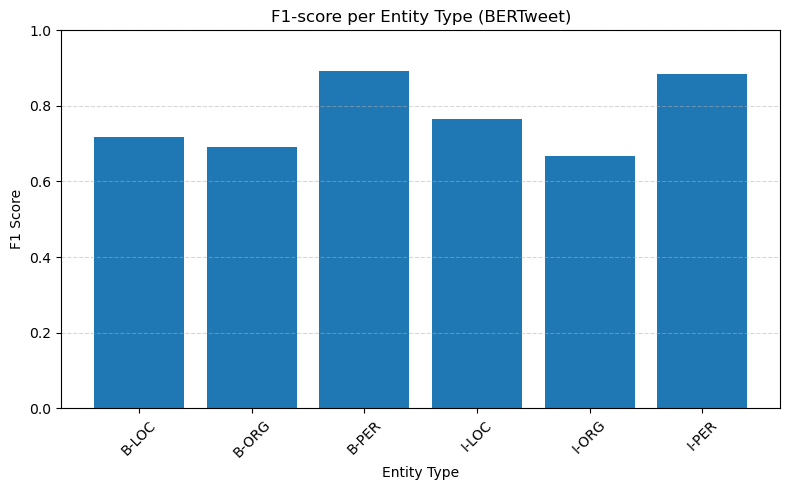

In [37]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Get prediction results
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions, axis=2)
label_list = dataset["train"].features["tags"].feature.names

# Flattened to a single list (minus -100)
true_labels = []
pred_labels = []
for true_seq, pred_seq in zip(labels, preds):
    for t, p in zip(true_seq, pred_seq):
        if t != -100:
            true_labels.append(label_list[t])
            pred_labels.append(label_list[p])

# Classification report
report = classification_report(true_labels, pred_labels, output_dict=True)

# Filter out non-physical categories (keep only B-XXX/I-XXX)
entity_types = [key for key in report.keys() if key.startswith("B-") or key.startswith("I-")]

# Extract F1 value
f1_scores = [report[etype]["f1-score"] for etype in entity_types]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(entity_types, f1_scores)
plt.title("F1-score per Entity Type (BERTweet)")
plt.xlabel("Entity Type")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Model Compare

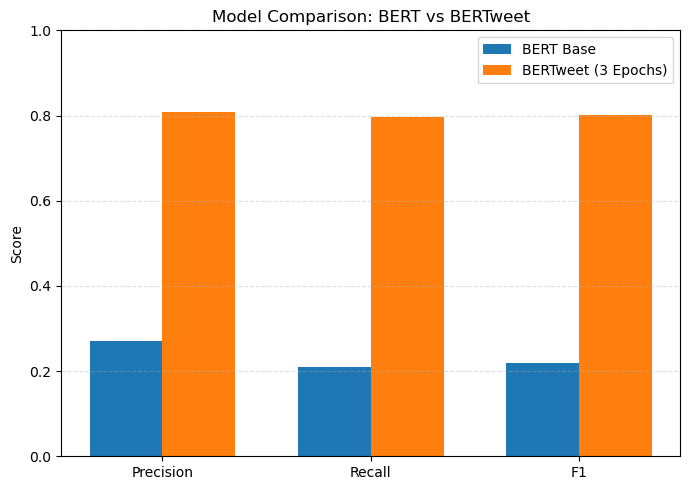

In [43]:
import matplotlib.pyplot as plt

# Model evaluation results
metrics = ["Precision", "Recall", "F1"]

bert_base = [0.27, 0.21, 0.22]
bertweet = [0.8074, 0.7975, 0.8004]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(7, 5))
plt.bar(x - width/2, bert_base, width, label='BERT Base')
plt.bar(x + width/2, bertweet, width, label='BERTweet (3 Epochs)')

plt.ylabel("Score")
plt.title("Model Comparison: BERT vs BERTweet")
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Error sample label distribution chart (error statistics bar chart)

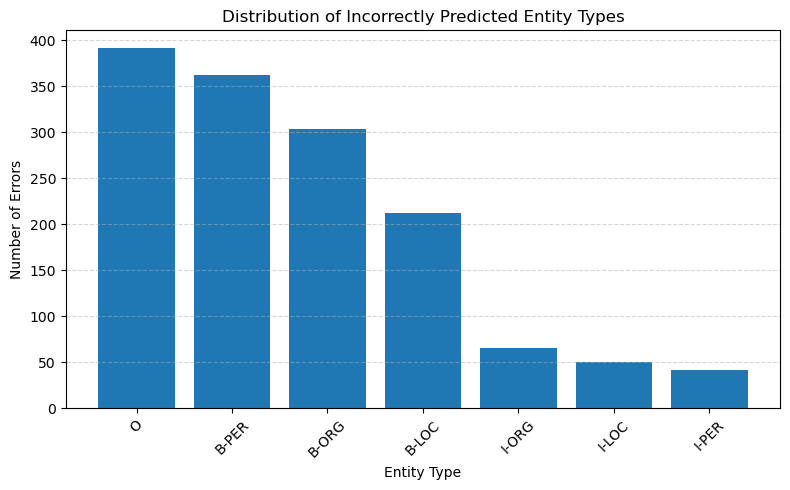

In [45]:
from collections import Counter
import matplotlib.pyplot as plt

# Labels for statistical prediction errors (true A, prediction B, A≠B)
error_labels = []

for true_seq, pred_seq in zip(labels, preds):
    for t, p in zip(true_seq, pred_seq):
        if t != -100 and t != p:
            error_labels.append(label_list[t])

# Count
error_count = Counter(error_labels)
sorted_labels = sorted(error_count.items(), key=lambda x: x[1], reverse=True)

# Split x and y
x_labels = [item[0] for item in sorted_labels]
x_values = [item[1] for item in sorted_labels]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x_labels, x_values)
plt.title("Distribution of Incorrectly Predicted Entity Types")
plt.xlabel("Entity Type")
plt.ylabel("Number of Errors")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Training set label frequency distribution diagram

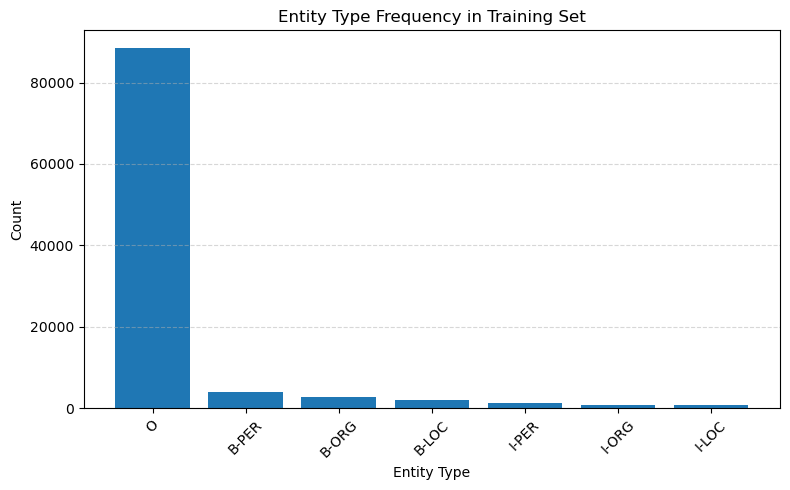

In [47]:
from itertools import chain

# Get all labels of the training set (remove -100)
train_labels = list(chain.from_iterable(dataset["train"]["tags"]))
train_label_names = [label_list[id] for id in train_labels]

# Frequency
train_freq = Counter(train_label_names)
sorted_train = sorted(train_freq.items(), key=lambda x: x[1], reverse=True)

x_labels = [item[0] for item in sorted_train]
x_values = [item[1] for item in sorted_train]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x_labels, x_values)
plt.title("Entity Type Frequency in Training Set")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Confusion matrix graph

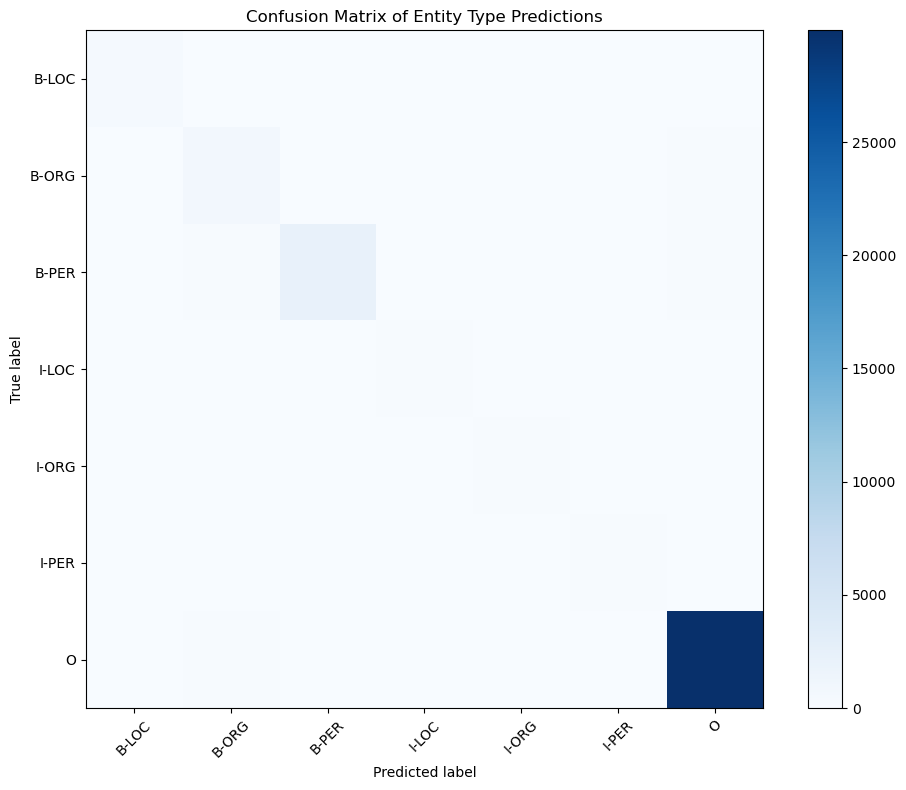

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fllatten label
y_true_flat = []
y_pred_flat = []

for true_seq, pred_seq in zip(labels, preds):
    for t, p in zip(true_seq, pred_seq):
        if t != -100:
            y_true_flat.append(label_list[t])
            y_pred_flat.append(label_list[p])

# All possible tags (avoid the "No class" warning)
labels_order = sorted(list(set(label_list)))

# confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels_order)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(include_values=False, cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix of Entity Type Predictions")
plt.tight_layout()
plt.show()


Line graph of training result

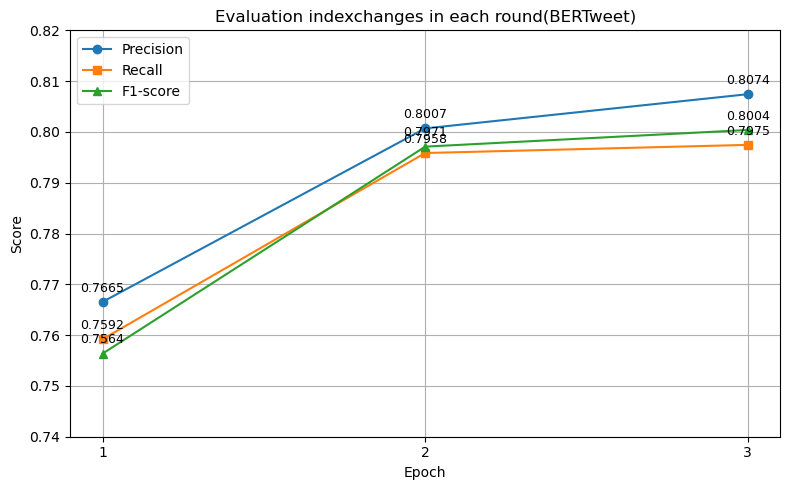

In [4]:
import matplotlib.pyplot as plt

# Evaluation index data of each round of the model
epochs = [1, 2, 3]
precision = [0.766539, 0.800693, 0.807429]
recall = [0.759195, 0.795848, 0.797451]
f1_score = [0.756354, 0.797104, 0.800384]

# Line chart
plt.figure(figsize=(8, 5))
plt.plot(epochs, precision, marker='o', label='Precision')
plt.plot(epochs, recall, marker='s', label='Recall')
plt.plot(epochs, f1_score, marker='^', label='F1-score')

# Add a specific value to each point
for i, (p, r, f) in enumerate(zip(precision, recall, f1_score)):
    plt.text(epochs[i], p + 0.002, f'{p:.4f}', ha='center', fontsize=9)
    plt.text(epochs[i], r + 0.002, f'{r:.4f}', ha='center', fontsize=9)
    plt.text(epochs[i], f + 0.002, f'{f:.4f}', ha='center', fontsize=9)

# Plot
plt.xticks(epochs)
plt.ylim(0.74, 0.82)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation indexchanges in each round(BERTweet)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
